Code to cluster participants by labeling their position in the model parameter space.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import seaborn as sns
import os
import pandas as pd
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy
import scipy.io

import sys
sys.path.append('/project/3014018.02/analysis_mri/'+
                'DataSharingCollection/Code/1.Behavior-FitModels/Functions/')
import choiceModels, costFunctions, penalizedModelFit

base_dir = '/project/3014018.02/analysis_mri/DataSharingCollection/'

## Label participants based on simulation clusters

#### Load fitted parameters

In [2]:
fittedParams = pd.read_csv(os.path.join(base_dir,
                     'Results/1.Behavior-FitModels/First_bests_all.csv'),
                           index_col=0).reset_index(drop=True)
model = 'MP_ppSOE'
fittedParams = fittedParams.loc[fittedParams['model']==model]
oldSubs = np.array(pd.read_csv(os.path.join(base_dir,'Data/subjectsIncluded_batch1.csv'),header=None,index_col=None))[0]
newSubs = np.array(pd.read_csv(os.path.join(base_dir,'Data/subjectsIncluded_batch2.csv'),header=None,index_col=None))[0]
fittedParams = fittedParams.loc[(fittedParams['sub'].isin(oldSubs)) | (fittedParams['sub'].isin(newSubs)),:]
fittedParams = fittedParams.reset_index(drop=True)
fittedParams.head()

,sub,model,theta,phi,SSE,AIC,BIC
0,124,MP_ppSOE,0.340718,0.055082,65.0,-7.882301,-3.220835
1,126,MP_ppSOE,0.078473,0.000799,205.0,79.413025,84.074491
2,128,MP_ppSOE,0.030199,0.059205,255.0,96.000296,100.661762
3,129,MP_ppSOE,0.206195,-0.095803,203.0,78.667921,83.329387
4,130,MP_ppSOE,0.078536,-0.017041,323.0,113.965843,118.627309


#### Load parameter space clustering

In [3]:
# Clustering
thetaLen = 101
phiLen = 101
metric_clustering = 'sqeuclidean'

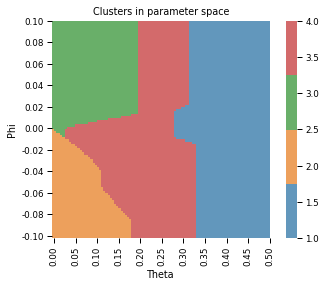

In [4]:
# Load clustering
sns.set_context('paper')
thetaPhi = pd.read_csv(os.path.join(base_dir,'Results/2.Behavior-ClusterModel/SimulationClustering_%i-by-%i_%s.csv'%(
    thetaLen,phiLen,metric_clustering)))
thetaPhiPivot = thetaPhi.pivot('theta','phi','cluster').T
# Define colors
ncols = len(np.unique(thetaPhi['cluster']))
sns.set_palette('tab10',ncols,desat=.8)
weight_colorsByWhites = [3,1]
colorMap = sns.color_palette()[0:ncols]
colorMap = list(np.add(np.multiply(colorMap,weight_colorsByWhites[0]),
                       np.multiply(np.ones([ncols,3]),weight_colorsByWhites[1]))
                /sum(weight_colorsByWhites))
ax = sns.heatmap(thetaPhiPivot,cmap=colorMap,square=True)
plt.xlabel('Theta')
plt.ylabel('Phi')
plt.yticks(np.arange(1,phiLen+1,(phiLen-1)/10),['%.2f'%i for i in np.arange(-.1,.1001,2/(float(phiLen)-1))])
plt.xticks(np.arange(1,thetaLen+1,(thetaLen-1)/10),['%.2f'%i for i in np.arange(0,.5001,5/(float(phiLen)-1))])
plt.title('Clusters in parameter space')
ax.invert_yaxis()
key = {1:'GR',2:'GA',3:'IA',4:'MO'}

#### Add cluster to subjects

In [5]:
fittedParams['clust'] = 0
for i in range(len(fittedParams)):
    thetaPhiDist = thetaPhi.copy()
    thetaPhiDist['euclidist'] = np.sqrt(np.square(fittedParams['theta'][i] - thetaPhi['theta']) +
                                        np.square(fittedParams['phi'][i] - thetaPhi['phi']))
    nearest = np.where(thetaPhiDist['euclidist'] == min(thetaPhiDist['euclidist']))[0][0]
    fittedParams.loc[i,'clust'] = thetaPhiDist['cluster'].iloc[nearest]
fittedParams['ClustName'] = fittedParams['clust'].map(key)
print fittedParams.head()
fittedParams.to_csv(os.path.join(base_dir,'Results/2.ClusterModel/ParticipantClustering.csv'))

   sub     model     theta       phi    SSE         AIC         BIC  clust  \
0  124  MP_ppSOE  0.340718  0.055082   65.0   -7.882301   -3.220835      1   
1  126  MP_ppSOE  0.078473  0.000799  205.0   79.413025   84.074491      4   
2  128  MP_ppSOE  0.030199  0.059205  255.0   96.000296  100.661762      3   
3  129  MP_ppSOE  0.206195 -0.095803  203.0   78.667921   83.329387      4   
4  130  MP_ppSOE  0.078536 -0.017041  323.0  113.965843  118.627309      4   

  ClustName  
0        GR  
1        MO  
2        IA  
3        MO  
4        MO  


In [6]:
fittedParams['ClustName'].value_counts()

IA    24
MO    21
GR     7
GA     5
Name: ClustName, dtype: int64

#### Plot participants scattered on parameter space (fig. 4A)

1 o 50
2 * 100
3 s 50
4 d 75


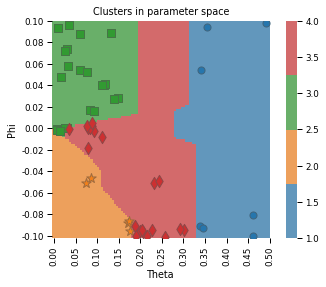

In [7]:
sns.set_context('paper')
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
sns.heatmap(thetaPhiPivot,ax=ax,cmap=colorMap)
ax.set_title('Clusters in parameter space')
ax.set_xlabel('Theta')
ax.set_ylabel('Phi')
plt.yticks(np.arange(1,phiLen+1,(phiLen-1)/10),['%.2f'%i for i in np.arange(-.1,.1001,2/(float(phiLen)-1))])
plt.xticks(np.arange(1,thetaLen+1,(thetaLen-1)/10),['%.2f'%i for i in np.arange(0,.5001,5/(float(phiLen)-1))])
ax.invert_yaxis()

# Define translation of scatter plot onto heatmap space
x_num = np.size(thetaPhiPivot,0)
y_num = np.size(thetaPhiPivot,1)
x_range = np.float(thetaPhiPivot.columns[x_num-1])-np.float(thetaPhiPivot.columns[0])
y_range = np.float(thetaPhiPivot.index[y_num-1])-np.float(thetaPhiPivot.index[0])
y_start = 0.1

# Define 
GRind = key.values().index('GR')+1
IAind = key.values().index('IA')+1
MOind = key.values().index('MO')+1
GAind = key.values().index('GA')+1
markers = ['o','*','s','d']
colors = sns.color_palette("tab10", 4,desat=.9)
edgecolors = np.divide(colorMap,1.5)
sizes = [50,100,50,75]
for i in np.arange(1,5,1):
    listInd = i-1
    marker = markers[listInd]; color = colors[listInd];
    size = sizes[listInd]; edgecolor = edgecolors[listInd];
    print i,marker,size
    thetaCur = fittedParams['theta'][fittedParams['clust']==i]
    phiCur = fittedParams['phi'][fittedParams['clust']==i]
    ax.scatter(x=.5+thetaCur/x_range*(x_num-1)+np.random.rand(1),y=.5+(y_start+phiCur)/y_range*(y_num-1),
               marker=marker,color=color,edgecolor=edgecolor,s=size,lw=1)
plt.savefig(os.path.join(base_dir,'Results/2.Behavior-ClusterModel/ClusterMap_Participants.pdf'),
            bbox_inches='tight')